In [14]:
pip install pandas unicode matplotlib seaborn nltk

Note: you may need to restart the kernel to use updated packages.


## 1. Text Preprocessing of the Economic Sector



Although it's not necessary, this function is created to normalize this text using nltk.

In [15]:
import unicodedata
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('spanish'))

def normalize_text(text):
    """
    Strip accents from input String, remove stopwords, and join words with underscores.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    # remove accents
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return '_'.join(filtered_words)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Merging All CSV Files into a Single DataFrame and Merging with sector_economico_csv

At this point, **the bronze datamart** is generated.

In [16]:

import os
import pandas as pd


sector_df = pd.read_csv('../data/sector_economico_clientes.csv',encoding='ISO-8859-1')
sector_df['sector_economico_normalizado'] = sector_df['Sector Economico'].map(lambda x: normalize_text(x).lower())

sector_mapping = sector_df.set_index('Cliente')['sector_economico_normalizado'].to_dict()
print(sector_mapping)

dataframes = []
directory = '../data/'
for filename in os.listdir(directory):
    if filename.startswith("DATOSCLIENTE"):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            
            customer_id = int(filename.replace('DATOSCLIENTE', '').replace('.csv', ''))
            df = pd.read_csv(filepath)
            df['ClienteId'] = customer_id
            dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['Sector_Economico'] = combined_df['ClienteId'].map(lambda x: sector_mapping.get(f'Cliente {x} '))

output_filepath = '../data/output/consumo_datamart_bronze.csv'
combined_df.to_csv(output_filepath, index=False)

print(f'Combined dataset saved to {output_filepath}')


{'Cliente 1 ': 'elaboracion_cacao_chocolate_productos_confiteria', 'Cliente 2 ': 'elaboracion_cacao_chocolate_productos_confiteria', 'Cliente 3 ': 'elaboracion_cacao_chocolate_productos_confiteria', 'Cliente 4 ': 'elaboracion_cacao_chocolate_productos_confiteria', 'Cliente 5 ': 'elaboracion_cacao_chocolate_productos_confiteria', 'Cliente 6 ': 'cultivo_arboles_frutales_nueces', 'Cliente 7 ': 'cultivo_arboles_frutales_nueces', 'Cliente 8 ': 'cultivo_arboles_frutales_nueces', 'Cliente 9 ': 'cultivo_arboles_frutales_nueces', 'Cliente 10 ': 'cultivo_arboles_frutales_nueces', 'Cliente 11 ': 'cultivo_frutos_nueces_arboles_arbustos', 'Cliente 12 ': 'cultivo_frutos_nueces_arboles_arbustos', 'Cliente 13 ': 'cultivo_hortalizas_melones_raices_tuberculos', 'Cliente 14 ': 'cultivo_frutos_nueces_arboles_arbustos', 'Cliente 15 ': 'cultivo_frutos_nueces_arboles_arbustos', 'Cliente 16 ': 'captacion_tratamiento_distribucion_agua', 'Cliente 17 ': 'captacion_tratamiento_distribucion_agua', 'Cliente 18 ': '


# 3. Data Quality Dimension: Completeness Analysis

**Findings:**

- 100% data completeness.
- 0.10% negative values in active_energy, which are indeed considered anomalous.


In [17]:
import pandas as pd

combined_df = pd.read_csv('../data/output/consumo_datamart_bronze.csv')

missing_percentages = combined_df.isnull().mean() * 100
duplicates = combined_df.duplicated().any()

negative_df= combined_df[combined_df['Active_energy']< 0]
print(f'Negative Values for Active_Energy  {negative_df.shape[0]*100/combined_df.shape[0]} %')

negative_df= combined_df[combined_df['Reactive_energy']< 0]
print(f'Negative Values for Rective_Energy  {negative_df.shape[0]*100/combined_df.shape[0]} %')

negative_df= combined_df[combined_df['Voltaje_FC']< 0]
print(f'Negative Values for Voltaje_FC  {negative_df.shape[0]*100/combined_df.shape[0]} %')

negative_df= combined_df[combined_df['Voltaje_FA']< 0]
print(f'Negative Values for Voltaje_FA  {negative_df.shape[0]*100/combined_df.shape[0]} %')

print('\n')

num_rows = combined_df.shape[0]

print(f"The dataset contains {num_rows} rows.")

print("Percentage of missing values per column:\n", missing_percentages)
print("\nAre there duplicated values in the dataset?", duplicates)


Negative Values for Active_Energy  0.1089712466957976 %
Negative Values for Rective_Energy  0.0 %
Negative Values for Voltaje_FC  0.0 %
Negative Values for Voltaje_FA  0.0 %


The dataset contains 463425 rows.
Percentage of missing values per column:
 Fecha               0.0
Active_energy       0.0
Reactive_energy     0.0
Voltaje_FA          0.0
Voltaje_FC          0.0
ClienteId           0.0
Sector_Economico    0.0
dtype: float64

Are there duplicated values in the dataset? False



### 3.1 Visualization of Negative Values in Active Energy

The negative values indeed correspond to the water distribution and treatment sector. But what does negative energy mean? It seems that this sector might also be generating energy on-site through the use of solar panels, which is then returned to the grid system.

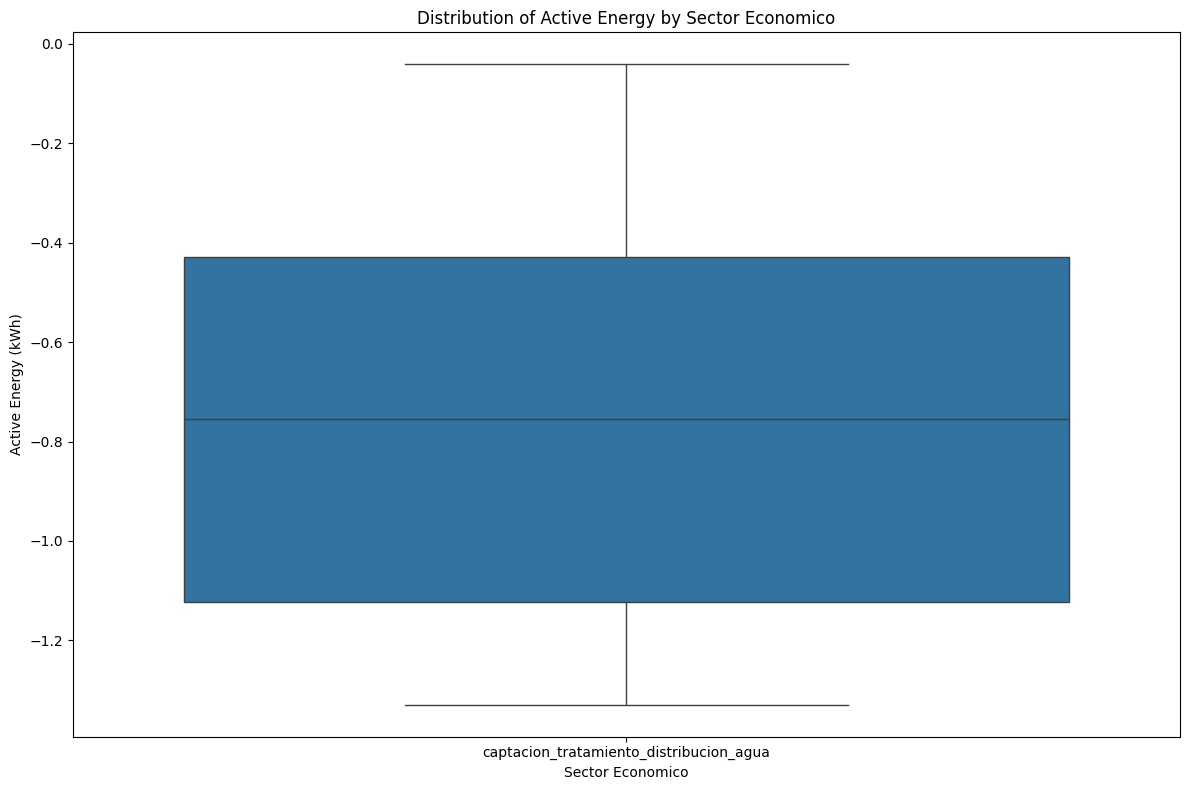

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_df = pd.read_csv('../data/output/consumo_datamart_bronze.csv')
negative_df = combined_df[combined_df['Active_energy'] <0]
plt.figure(figsize=(12, 8))
sns.boxplot(x='Sector_Economico', y='Active_energy', data=negative_df)
plt.xticks(rotation=0)  
plt.title('Distribution of Active Energy by Sector Economico')
plt.ylabel('Active Energy (kWh)')
plt.xlabel('Sector Economico')

plt.tight_layout()  
plt.show()

# 4. General Understanding of the Data

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from  IPython.display import display


combined_df = pd.read_csv('../data/output/consumo_datamart_bronze.csv')

num_records = combined_df.shape[0]
num_attributes = combined_df.shape[1]
print(f'Number of records: {num_records}')
print(f'Number of attributes: {num_attributes}')

display(combined_df.dtypes)
display(combined_df.describe().T)


for column in combined_df[['Sector_Economico']].select_dtypes(include=['object']).columns:
    print(f'Frequency of categories for {column}:')
    display(combined_df[column].value_counts())
    print()
    
# Completeness
missing_values = combined_df.isnull().sum()
print(f'Missing values for each attribute:\n{missing_values}')

# Unicity 
duplicate_rows = combined_df.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_rows}')

Number of records: 463425
Number of attributes: 7


Fecha                object
Active_energy       float64
Reactive_energy     float64
Voltaje_FA          float64
Voltaje_FC          float64
ClienteId             int64
Sector_Economico     object
dtype: object

,count,mean,std,min,25%,50%,75%,max
Active_energy,463425.0,1.472050,1.718780,-1.329018,0.242788,0.810771,1.992488,14.622644
Reactive_energy,463425.0,0.873086,1.158846,0.000000,0.112832,0.380650,1.222834,11.135141
Voltaje_FA,463425.0,1420.188470,766.299118,0.031000,719.462874,1625.493463,2037.276385,4266.229746
Voltaje_FC,463425.0,1438.515836,746.447449,0.031000,748.148254,1634.696089,2040.554497,4399.038932
ClienteId,463425.0,13.682710,8.407285,1.000000,6.000000,13.000000,20.000000,30.000000


Frequency of categories for Sector_Economico:


Sector_Economico
elaboracion_cacao_chocolate_productos_confiteria    98405
cultivo_arboles_frutales_nueces                     98405
captacion_tratamiento_distribucion_agua             97500
venta_mayor_metales_minerales_metaliferos           57075
cultivo_frutos_nueces_arboles_arbustos              53415
cultivo_hortalizas                                  44625
cultivo_hortalizas_melones_raices_tuberculos        14000
Name: count, dtype: int64


Missing values for each attribute:
Fecha               0
Active_energy       0
Reactive_energy     0
Voltaje_FA          0
Voltaje_FC          0
ClienteId           0
Sector_Economico    0
dtype: int64
Number of duplicate rows: 0


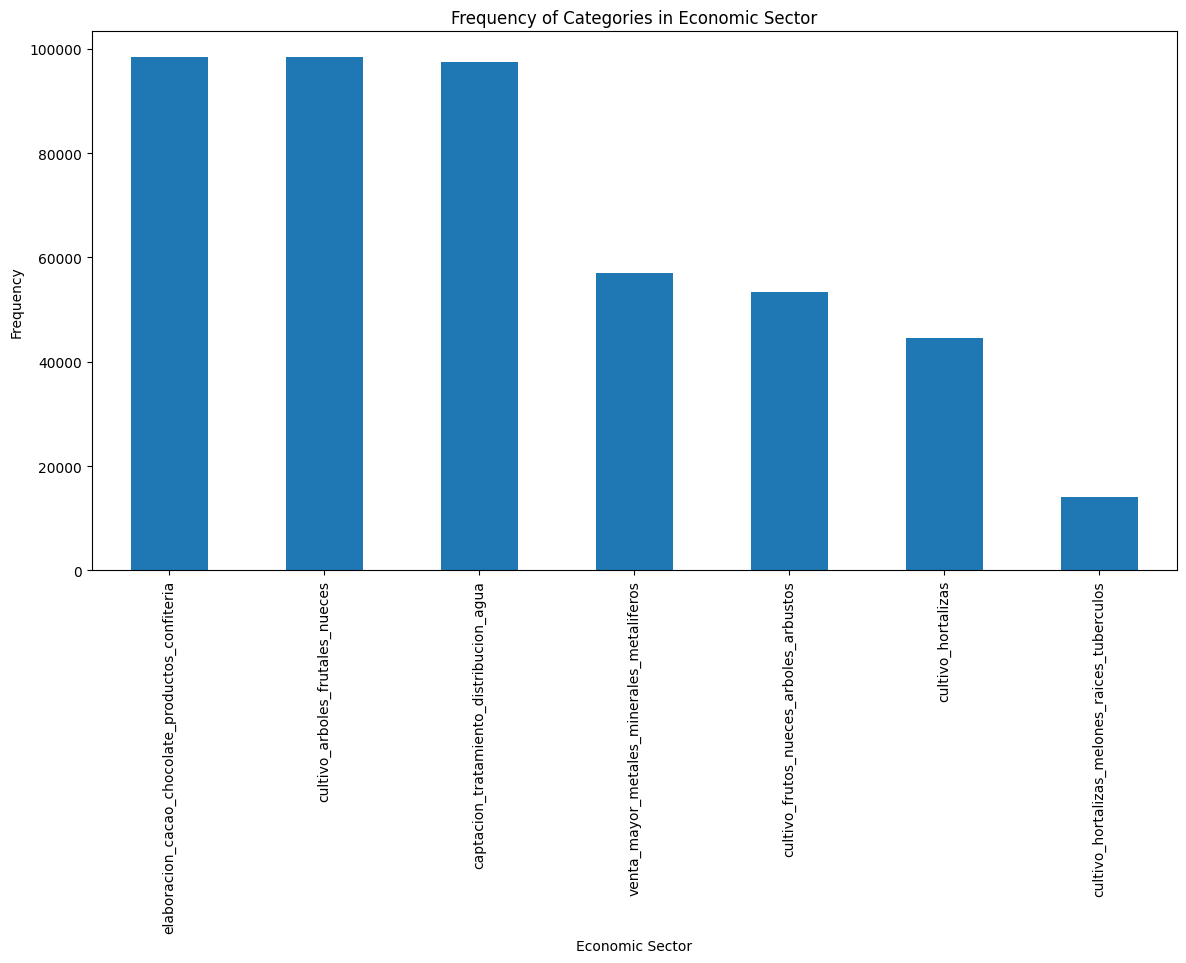

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


combined_df = pd.read_csv('../data/output/consumo_datamart_bronze.csv')
sector_counts = combined_df['Sector_Economico'].value_counts()
sector_counts.plot(kind='bar', figsize=(14, 7))

plt.title('Frequency of Categories in Economic Sector')
plt.xlabel('Economic Sector')
plt.ylabel('Frequency')

plt.show()
